# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [4]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Einlesen mit h5py

In [5]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [6]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None

## Daten einlesen mit pyfact

In [7]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

In [8]:
#crab_events.head()

# Limits für theata^2 - Plot

In [9]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

In [10]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [11]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
# mask = (crab_events_pred.theta_deg_off_1 < limit_theta) | (crab_events_pred.theta_deg_off_2 < limit_theta) | (crab_events_pred.theta_deg_off_3 < limit_theta) | (crab_events_pred.theta_deg_off_4 < limit_theta) | (crab_events_pred.theta_deg_off_5 < limit_theta)
# crab_events_sel_all = crab_events_pred[mask]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [12]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


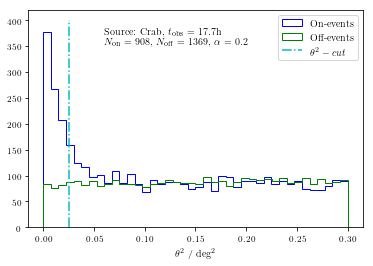

In [13]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))

print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

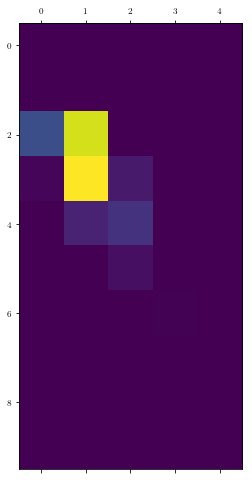

In [14]:
matrix, xedge, yedge = np.histogram2d(
    gammas_sel['gamma_energy_prediction'],
    gammas_sel['corsika_event_header_total_energy'], 
                                         bins=[
                                             np.logspace(np.log10(200),np.log10(40e3),11),
                                             np.logspace(np.log10(200),np.log10(40e3),6),
                                         ],
                                         normed='True')
plt.matshow(matrix)

Text(0, 0.5, 'gamma\\_true\\_energy')

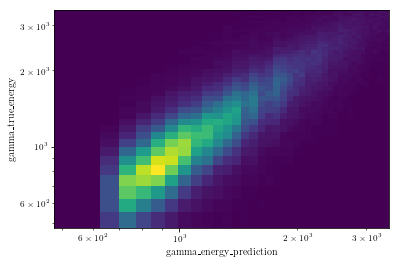

In [15]:
# definiere Grenzquantile für plot
up = np.quantile(gammas['corsika_event_header_total_energy'], 0.9)
low = np.quantile(gammas['corsika_event_header_total_energy'], 0.1)

plt.hist2d(gammas_sel['gamma_energy_prediction'],
                                         gammas_sel['corsika_event_header_total_energy'], 
                                         bins=40, 
                                         normed='True',
                                         range=[[low, up],[low, up]])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma\_energy\_prediction') 
plt.ylabel('gamma\_true\_energy')

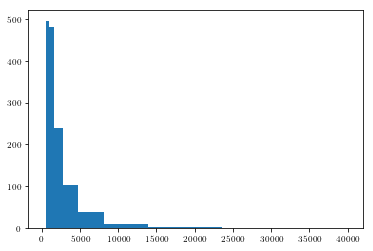

In [16]:
# Untergrund binnen
b, bins, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge)

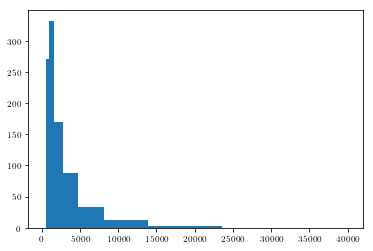

In [17]:
# Signal binnen
g, bins, p = plt.hist(crab_events_sel['gamma_energy_prediction'], bins=xedge)

In [18]:
print(matrix)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.28589856e-08 3.63759225e-07 1.14380482e-09 0.00000000e+00
  0.00000000e+00]
 [5.38297265e-09 3.88071691e-07 2.78859174e-08 2.67039006e-11
  0.00000000e+00]
 [8.20978661e-11 3.65676108e-08 5.68209118e-08 3.09629313e-10
  0.00000000e+00]
 [0.00000000e+00 4.92459138e-10 1.64960443e-08 1.27636253e-09
  1.39455250e-12]
 [0.00000000e+00 1.97219506e-11 9.46659158e-10 1.55088719e-09
  1.14116034e-11]
 [0.00000000e+00 0.00000000e+00 1.24739087e-11 3.51706140e-10
  3.11737167e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70763561e-11
  2.73431949e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.59629818e-12]]


In [19]:
# Penrose-Moore Pseudoinverse ausrechnen (nicht quadratisch)
inv = np.linalg.pinv(matrix)
print(inv)

[[-8.68068201e-10  3.73081280e-10  1.14125133e+07 -1.11783365e+07
   5.09476333e+06  6.35174106e+05 -1.37734158e+06  1.11996333e+05
   4.10878213e+05  4.07607940e+04]
 [ 2.17996530e-10 -9.78995154e-11 -1.64549031e+05  2.85927049e+06
  -1.35836317e+06 -1.64091423e+05  3.64963792e+05 -2.98026707e+04
  -1.08943722e+05 -1.08071202e+04]
 [-1.18062310e-09  1.08969412e-09  8.81252902e+04 -1.79755256e+06
   1.81850182e+07  1.28796138e+06 -4.76957075e+06  4.15090731e+05
   1.43810187e+06  1.42548858e+05]
 [-6.75472174e-09 -3.11035685e-09 -4.83180029e+05  9.94021144e+06
  -1.05243649e+08  3.22073490e+08  4.13107541e+08 -4.88841008e+07
  -1.31867329e+08 -1.30164708e+07]
 [ 3.36912336e-07 -3.44879401e-06  6.49554794e+06 -1.33654927e+08
   1.41649022e+09 -4.63004864e+09 -6.42694026e+08  1.75802786e+10
   1.68804649e+10  1.61096735e+09]]


Unfolded: [-1.27686722e+09 -2.92070180e+08 -1.03456737e+09 -1.20662078e+09
  7.70417502e+10]
 shape (5,)


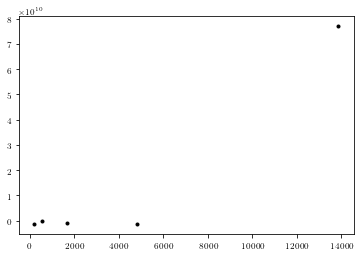

In [20]:
# Naive Entfaltung
ev = g-b
print('Unfolded: {}\n shape {}'.format(inv.dot(ev), np.shape(inv.dot(ev))))
plt.plot(yedge[:-1], inv.dot(ev), 'k.')

[ 0.00000000e+00  0.00000000e+00 -4.95974682e+02 -4.80971779e+02
 -2.39994468e+02 -1.02999076e+02 -3.89999284e+01 -8.99999473e+00
 -9.99999727e-01  4.95892952e-09]


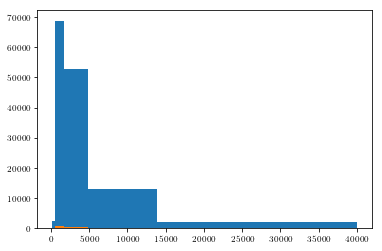

In [35]:
#Entfaltung mit Likelihood-Fit
f, bins, p = plt.hist(gammas_sel['corsika_event_header_total_energy'], bins=yedge)
b, bins, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge)
lam = matrix.dot(f)-b
print(lam)

In [ ]:
likelihood = 